In [28]:
import keras
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re
import seaborn as sn
import urllib.request
import zipfile

from keras import Input
from keras.callbacks import EarlyStopping
from keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, Dropout, GRU, Bidirectional, LSTM
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import plot_model, to_categorical
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [3]:
# Obtain final Amazon dataset.
data = pd.read_csv('../../data/results/amazon_final.csv')

In [4]:
# Define dimensionality of word embeddings.
embedding_dim = 300

# Define max input length.
max_seq_len = 500

In [5]:
# Encode emotion category.
data['PREDICTION'] = data['PREDICTION'].apply({'neutral':0, 'fear':1, 'sadness':2, 'joy':3,'anger':4}.get)
data

,REVIEW_TEXT,VERACITY,PREDICTION,joy,fear,neutral,anger,sadness
0,"When least you think so, this product will sav...",Fake,0,0.108776,0.035421,0.675116,0.196709,0.020431
1,Lithium batteries are something new introduced...,Fake,4,0.125708,0.103117,0.087749,0.627661,0.077903
2,I purchased this swing for my baby. She is 6 m...,Fake,0,0.261877,0.077076,0.413570,0.157695,0.113803
3,I was looking for an inexpensive desk calcolat...,Fake,1,0.107387,0.446936,0.163032,0.203908,0.093214
4,I m not sure what this is supposed to be but I...,Fake,0,0.229221,0.025874,0.672216,0.091756,0.014439
...,...,...,...,...,...,...,...,...
13980,These shoes are absolutely amazing. They are t...,Real,3,0.765827,0.011777,0.155121,0.068278,0.009005
13981,"My son had ordered it but when it arrived, he ...",Real,4,0.072390,0.062060,0.028264,0.771714,0.088904
13982,These shoes fit well. I purchased to wear to ...,Real,3,0.678554,0.028018,0.191851,0.054362,0.058558
13983,"These slippers are soft, warm, and very cozy. ...",Real,3,0.561892,0.037288,0.250742,0.157339,0.009371


In [7]:
def clean_text(text):
    text = text.lower()
             
    # Process opeations and common punctuation.           
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    
    # Remove all remaining symbols.
    text = re.sub(r'[^a-z0-9]', ' ', text)
    
    # Remove stopwords and lemmatize.
    text = text.split()
    stop_words = stopwords.words("english")
    text = [tok for tok in text if tok not in stop_words]
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(w) for w in text]
    return ' '.join(text

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [15]:
data['REVIEW_TEXT'] = data['REVIEW_TEXT'].apply(lambda x: clean_text(x))

In [62]:
# Leave 10% of data for test set, and split training test into training and validation subsets.
X_train, X_test, y_train, y_test = train_test_split(data[['REVIEW_TEXT', 'PREDICTION', 'joy', 'fear', 'neutral', 'anger', 'sadness']], data.VERACITY, test_size=0.1)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.1)

In [63]:
# Obtain review texts for data and each data subset.
texts_train = X_train.REVIEW_TEXT.tolist()
texts_dev = X_dev.REVIEW_TEXT.tolist()
texts_test = X_test.REVIEW_TEXT.tolist()
texts = data.REVIEW_TEXT

In [64]:
# Fit tokenizer on review texts.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_dev = tokenizer.texts_to_sequences(texts_dev)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# Store the number of unique words (one added for padding).
vocab_size = len(index_of_words) + 1

In [65]:
# Pad data.
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_dev_pad = pad_sequences(sequence_dev, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

In [66]:
# Encode veracity predictions.
encoding = {
    'Fake': 0,
    'Real': 1,
}

y_train = [encoding[y] for y in y_train]
y_dev = [encoding[y] for y in y_dev]
y_test = [encoding[y] for y in y_test]

In [67]:
y_train = np.array(y_train)
y_dev = np.array(y_dev)
y_test = np.array(y_test)

In [68]:
def create_embedding_matrix(filepath, word_index, embedding_dim, vocab_size):
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [69]:
# Obtain wiki vectors.
fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('Done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

In [70]:
# Get embedding matrix.
embedding_matrix = create_embedding_matrix(fname, index_of_words, embedding_dim, vocab_size)
embedding_matrix.shape

(21767, 300)

In [71]:
# Obtain emotion categories.
X_emo_train = X_train[['PREDICTION', 'joy', 'sadness', 'fear', 'anger', 'neutral']].values
X_emo_dev = X_dev[['PREDICTION', 'joy', 'sadness', 'fear', 'anger', 'neutral']].values
X_emo_test = X_test[['PREDICTION', 'joy', 'sadness', 'fear', 'anger', 'neutral']].values

In [72]:
# Define model input shapes.
input_text = Input(shape=(max_seq_len,))
input_emo = Input(shape=(6,))

### Obtain classification using text alone ###

In [73]:
# Construct model.
embedding_layer = Embedding(vocab_size,
                            embedding_dim,
                            input_length = max_seq_len,
                            weights = [embedding_matrix],
                            trainable=False)(input_text)
cnn_layer = Conv1D(64 , 5, activation='relu')(embedding_layer)
pool_layer = MaxPooling1D(pool_size=4)(cnn_layer)
lstm_layer = LSTM(100)(pool_layer) 
dense_layer = Dense(64, activation='relu')(lstm_layer)
output = Dense(1, activation='sigmoid')(dense_layer)

In [74]:
model_text = Model(inputs=input_text, outputs=output)

In [75]:
opt = keras.optimizers.Adam(learning_rate=0.00001)
model_text.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])
print(model_text.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 500, 300)          6530100   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 496, 64)           96064     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 124, 64)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                6464      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65  

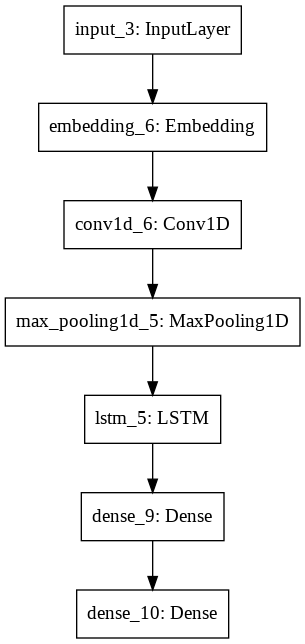

In [76]:
plot_model(model_text, to_file='model_plot.png')

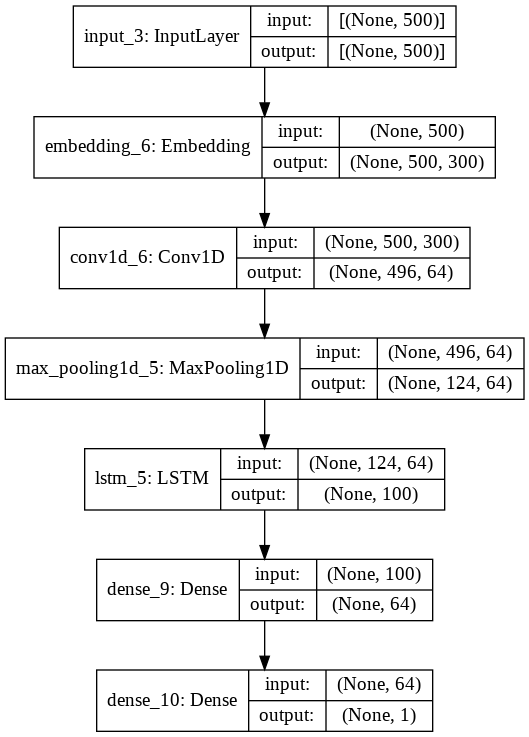

In [77]:
plot_model(model_text, to_file='model_text.png', show_shapes=True)

In [78]:
# Define stopping criteria and fit model.
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

history_text = model_text.fit(x=X_train_pad, 
                              y=y_train, 
                              batch_size=64, 
                              epochs=50, 
                              verbose=1,
                              validation_data=(X_dev_pad, y_dev), 
                              callbacks=[early_stopping_monitor])

Epoch 1/50
177/177 [==============================] - 6s 25ms/step - loss: 0.6921 - acc: 0.5200 - val_loss: 0.6892 - val_acc: 0.5496
Epoch 2/50
177/177 [==============================] - 4s 22ms/step - loss: 0.6898 - acc: 0.5237 - val_loss: 0.6877 - val_acc: 0.5576
Epoch 3/50
177/177 [==============================] - 4s 22ms/step - loss: 0.6885 - acc: 0.5376 - val_loss: 0.6856 - val_acc: 0.5679
Epoch 4/50
177/177 [==============================] - 4s 22ms/step - loss: 0.6869 - acc: 0.5547 - val_loss: 0.6834 - val_acc: 0.5751
Epoch 5/50
177/177 [==============================] - 4s 22ms/step - loss: 0.6834 - acc: 0.5660 - val_loss: 0.6801 - val_acc: 0.5774
Epoch 6/50
177/177 [==============================] - 4s 22ms/step - loss: 0.6790 - acc: 0.5657 - val_loss: 0.6763 - val_acc: 0.5798
Epoch 7/50
177/177 [==============================] - 4s 22ms/step - loss: 0.6762 - acc: 0.5620 - val_loss: 0.6733 - val_acc: 0.5782
Epoch 8/50
177/177 [==============================] - 4s 22ms/step - 

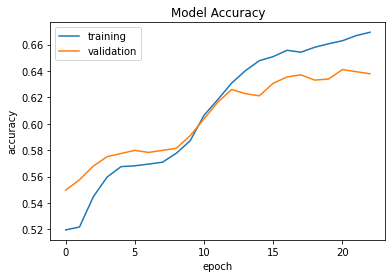

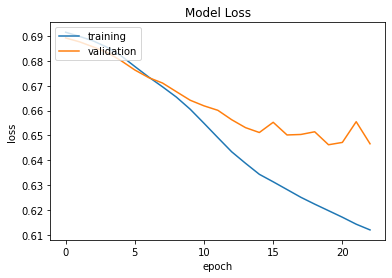

In [79]:
# Plot accuracy and loss of the model.
plt.plot(history_text.history['acc'])
plt.plot(history_text.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

plt.plot(history_text.history['loss'])
plt.plot(history_text.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [80]:
# Make predictions and record key metrics.
predictions = model_text.predict(X_test_pad)

In [81]:
predictions = [1 if pred > 0.5 else 0 for pred in predictions]

In [82]:
print('Classification report: ') 
print(classification_report(y_test, predictions, digits=4, target_names = ['Fake', 'Real']))

Classification report: 
              precision    recall  f1-score   support

        Fake     0.6105    0.7816    0.6855       728
        Real     0.6595    0.4590    0.5413       671

    accuracy                         0.6269      1399
   macro avg     0.6350    0.6203    0.6134      1399
weighted avg     0.6340    0.6269    0.6164      1399



Text(0.5, 1.0, 'Veracity Predictions on Texts Alone')

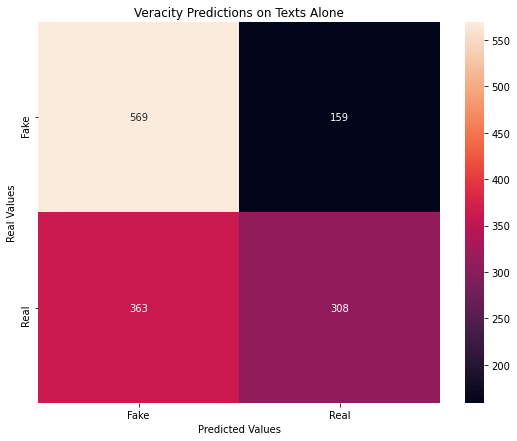

In [83]:
df_cm = pd.DataFrame(confusion_matrix(y_test, predictions), index = [i for i in ['Fake', 'Real']],
                  columns = [i for i in ['Fake', 'Real']])
plt.figure(figsize = (9,7))
hm = sn.heatmap(df_cm, annot=True, fmt='g')
hm.set_xlabel('Predicted Values')
hm.set_ylabel('Real Values')
hm.set_title('Veracity Predictions on Texts Alone')

In [96]:
# Store model for future use.
model_text.save('../../trained_models/veracity_text_cnn_lstm.h5')

### Obtain classification results on texts with emotions ###

In [87]:
# Construct model.
embedding_layer = Embedding(vocab_size,
                            embedding_dim,
                            input_length = max_seq_len,
                            weights = [embedding_matrix],
                            trainable=False)(input_text)

cnn_layer = Conv1D(64 , 5, activation='relu')(embedding_layer)
pool_layer = MaxPooling1D(pool_size=4)(cnn_layer)
lstm_layer = LSTM(100)(pool_layer) 
concat_layer = Concatenate()([lstm_layer, input_emo])
dense_layer = Dense(64, activation='relu')(concat_layer)
output = Dense(1, activation='sigmoid')(dense_layer)

In [88]:
model_emo = Model(inputs=[input_text, input_emo], outputs=output)

In [89]:
opt = keras.optimizers.Adam(learning_rate=0.00001)
model_emo.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])
print(model_emo.summary())

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 500, 300)     6530100     input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 496, 64)      96064       embedding_8[0][0]                
__________________________________________________________________________________________________
max_pooling1d_7 (MaxPooling1D)  (None, 124, 64)      0           conv1d_8[0][0]                   
____________________________________________________________________________________________

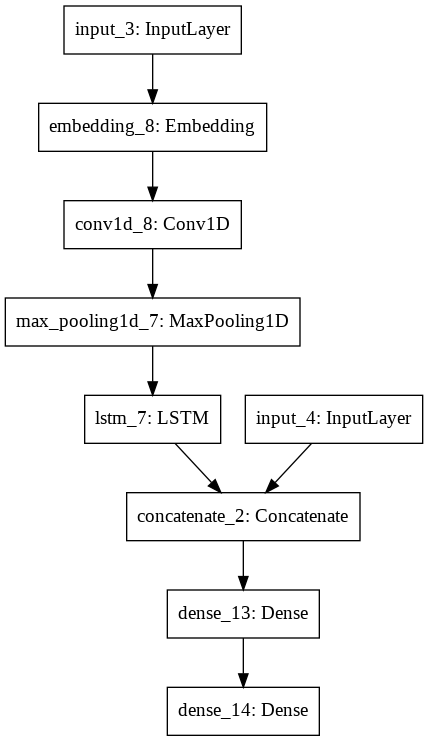

In [90]:
plot_model(model_emo, to_file='model_emo_plot.png')

In [91]:
# Define stopping criteria and fit model.
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

history_emo = model_emo.fit(x=[X_train_pad, X_emo_train], 
                            y=y_train, 
                            batch_size=64, 
                            epochs=50, 
                            verbose=1,
                            validation_data=([X_dev_pad, X_emo_dev], y_dev), 
                            callbacks=[early_stopping_monitor])

Epoch 1/50
177/177 [==============================] - 6s 25ms/step - loss: 0.6899 - acc: 0.5325 - val_loss: 0.6865 - val_acc: 0.5624
Epoch 2/50
177/177 [==============================] - 4s 22ms/step - loss: 0.6897 - acc: 0.5324 - val_loss: 0.6855 - val_acc: 0.5631
Epoch 3/50
177/177 [==============================] - 4s 22ms/step - loss: 0.6873 - acc: 0.5416 - val_loss: 0.6845 - val_acc: 0.5679
Epoch 4/50
177/177 [==============================] - 4s 22ms/step - loss: 0.6865 - acc: 0.5484 - val_loss: 0.6828 - val_acc: 0.5846
Epoch 5/50
177/177 [==============================] - 4s 22ms/step - loss: 0.6832 - acc: 0.5661 - val_loss: 0.6811 - val_acc: 0.5886
Epoch 6/50
177/177 [==============================] - 4s 22ms/step - loss: 0.6810 - acc: 0.5715 - val_loss: 0.6788 - val_acc: 0.5878
Epoch 7/50
177/177 [==============================] - 4s 22ms/step - loss: 0.6798 - acc: 0.5719 - val_loss: 0.6758 - val_acc: 0.5870
Epoch 8/50
177/177 [==============================] - 4s 22ms/step - 

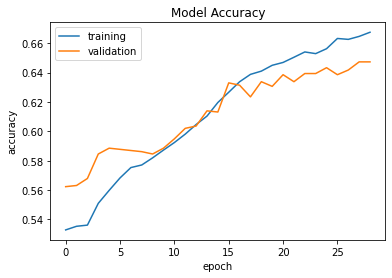

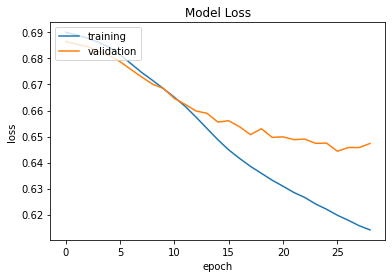

In [92]:
# Plot accuracy and loss of the model.
plt.plot(history_emo.history['acc'])
plt.plot(history_emo.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

plt.plot(history_emo.history['loss'])
plt.plot(history_emo.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [93]:
# Make predictions and record key metrics.
predictions = model_emo.predict([X_test_pad, X_emo_test])

In [94]:
predictions = [1 if pred > 0.5 else 0 for pred in predictions]

In [95]:
print('Classification report: ') 
print(classification_report(y_test, predictions, digits=4, target_names = ['Fake', 'Real']))

Classification report: 
              precision    recall  f1-score   support

        Fake     0.6177    0.7459    0.6758       728
        Real     0.6442    0.4993    0.5626       671

    accuracy                         0.6276      1399
   macro avg     0.6310    0.6226    0.6192      1399
weighted avg     0.6304    0.6276    0.6215      1399



Text(0.5, 1.0, 'Veracity Predictions on Texts with Emotions')

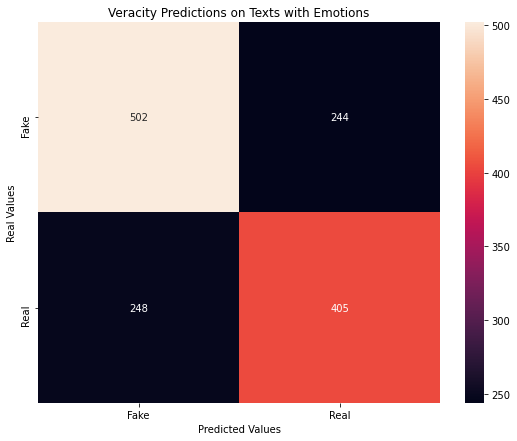

In [ ]:
df_cm = pd.DataFrame(confusion_matrix(y_test, predictions), index = [i for i in ['Fake', 'Real']],
                  columns = [i for i in ['Fake', 'Real']])
plt.figure(figsize = (9,7))
hm = sn.heatmap(df_cm, annot=True, fmt='g')
hm.set_xlabel('Predicted Values')
hm.set_ylabel('Real Values')
hm.set_title('Veracity Predictions on Texts with Emotions')

In [97]:
# Store model for future use.
model_emo.save('../../trained_models/veracity_text_emotions_cnn_lstm.h5')